In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from itertools import product
from sklearn.metrics import r2_score
import csv
from vme import VME
from envelope import spline_envelope
import itertools

In [2]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [36]:
# linux path
# path1 = './'
# path2 = '/'

# windows path
path1 = '.\\'
path2 = '\\'

In [3]:
DS = pd.read_csv("DailyDelhiClimateTrain.csv", decimal=',')
DS['date'] = pd.to_datetime(DS['date'])
DS['meantemp'] = pd.to_numeric(DS['meantemp'])
DS.set_index("date", inplace=True)
DS.dropna(inplace=True)
TS = DS['meantemp']
TS

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64

In [4]:
index = TS.index
index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

In [5]:
k = 4 # количество декомпозиций
f = TS[::].values # значения временного ряда, в дальнейшем - вычеты
u = np.zeros(k, dtype=list) # декомпозиции
low = np.zeros(k, dtype=list) # верхние огибающие
high = np.zeros(k, dtype=list) # нижние огибающие


for i in range(0,k):
    low_envelope, high_envelope = spline_envelope(f,dmin=1,dmax=1)
    low[i] = low_envelope
    high[i] = high_envelope
    # u[i] = (high_envelope + low_envelope)/2
    u[i] = f - (high_envelope + low_envelope)/2
    f = f - u[i]


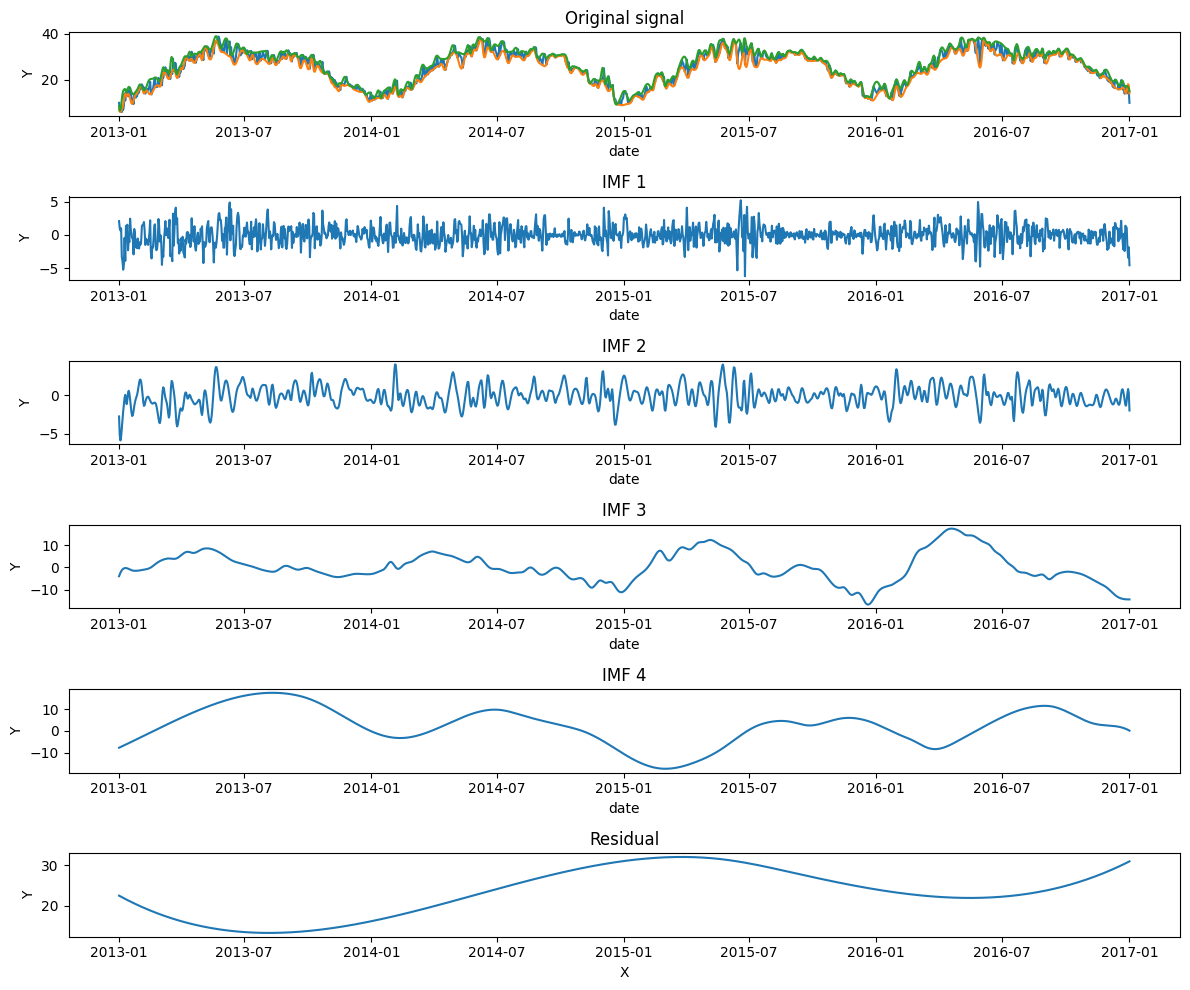

In [6]:
fig, axs = plt.subplots(figsize=(12,10), nrows=k+2)

# plt.subplot(2,1,1)
axs[0].set(xlabel = 'date', ylabel='Y')
axs[0].plot(index, TS[::].values)
axs[0].plot(index, low[0])
axs[0].plot(index, high[0])
axs[0].set_title('Original signal')

# plt.subplot(2,1,2)
for i in range(k):
    axs[i+1].plot(index, u[i])
    axs[i+1].set_title(f'IMF {i+1}')
    axs[i+1].set(xlabel = 'date', ylabel='Y')

# plt.subplot(2,2,2)
axs[k+1].plot(index, f)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

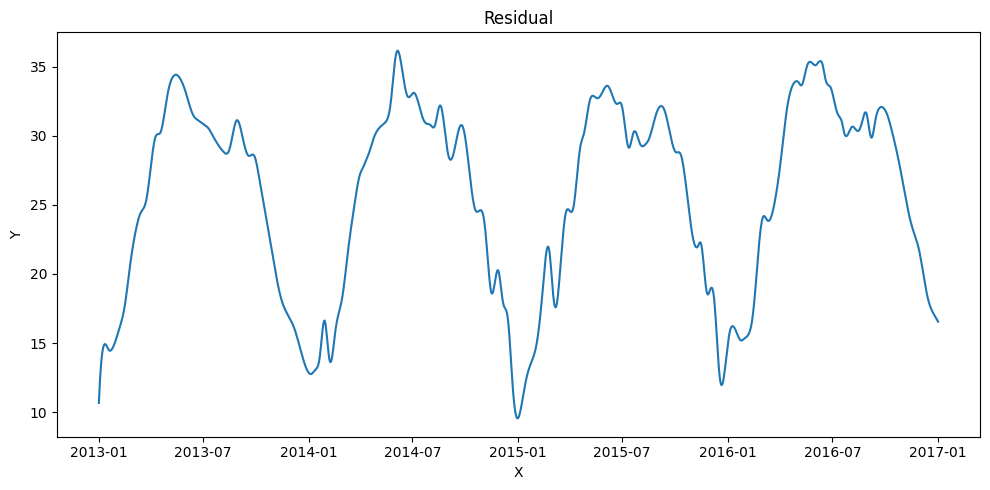

In [7]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


sum_imfs = 0
for i in range(2,k):
    sum_imfs += u[i]

sum_imfs += f
# axs.plot(index, TS[::].values)
axs.plot(index, sum_imfs)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [8]:
Trend = f + u[3]+ u[2]
Component_of_TS = Trend[::]
Component_name = "Trend"
range_of_imfs = range(8)

Season = u[1]
Component_of_TS = Season[::]
Component_name = "Season"
range_of_imfs = range(1,8)

Noise = u[0]
Component_name = "Noise"
range_of_imfs = range(9, 1, -1)
Component_of_TS = Noise[::]

# тестовый анализ

In [67]:
len(TS)

1462

In [69]:
TS

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64

In [40]:
u, _, _ = VME(f, Alpha=10000, omega_int=101, fs=20000, tau=1, tol=1e-6)

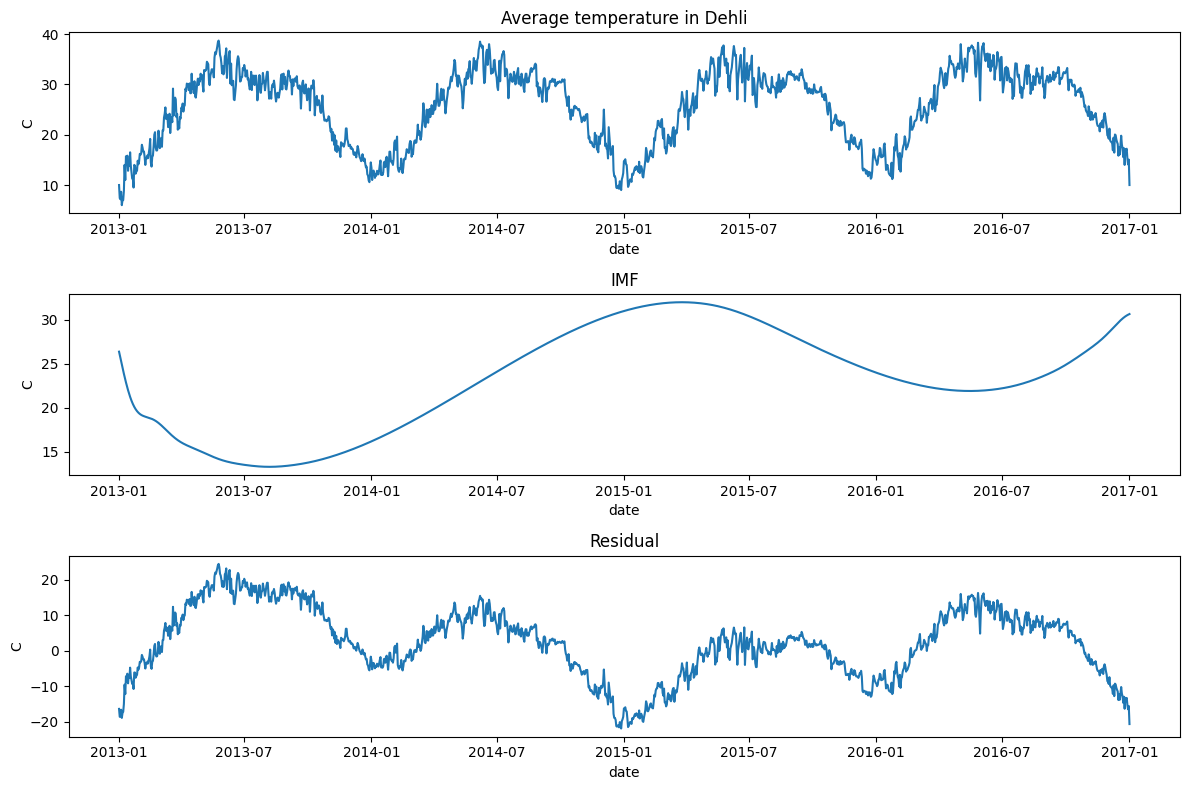

In [41]:
fig, axs = plt.subplots(figsize=(12,8), nrows=3)

axs[0].plot(index, TS[::].values)
axs[0].set_title('Average temperature in Dehli')
axs[0].set(xlabel = 'date', ylabel='C')

axs[1].plot(index, u.T)
axs[1].set_title('IMF')
axs[1].set(xlabel = 'date', ylabel='C')

axs[2].plot(index, TS[::].values - u.T)
axs[2].set_title('Residual')
axs[2].set(xlabel = 'date', ylabel='C')

plt.tight_layout()

# Тренд

In [43]:
# набор параметров
alpha = (0, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000) # moderate bandwidth constraint
omega_init = (1, 501, 1001, 2501, 5001, 7501, 10001, 15001, 20001, 25001, 30001, 35001, 40001, 45001, 50001)
tau = (0, 1, 2, 3, 4, 5) # noise-tolerance (no strict fidelity enforcement)
fs = 20000
tol = 1e-6

featurecount = 5
params_set = list(product(alpha, omega_init, tau))

In [44]:
best_params = np.zeros((10), dtype=dict)
best_metriks = np.zeros((4), dtype=dict)

f = np.zeros((1462), dtype=list)
k_i = 0


In [45]:
#  R2
MetricName = "R2"
calculate_metric = lambda y, y_pred: r2_score(y, y_pred)

default_value = -np.inf
maxmin = lambda criteria: np.max(criteria)
arg_maxmin = lambda criteria: np.argmax(criteria)
find_new_best_params = lambda max_criteria, best_metriks: max_criteria > best_metriks


# #  R2Adj
# MetricName = "R2Adj"
# calculate_metric = lambda y, y_pred, featurecount: r2_score_adjusted(y, y_pred, featurecount)


# #  AIC
# MetricName = "AIC"
# calculate_metric = lambda y, y_pred, k: calculate_aic(y, y_pred, k)

# default_value = np.inf
# maxmin = lambda criteria: np.min(criteria)
# arg_maxmin = lambda criteria: np.argmin(criteria)
# find_new_best_params = lambda max_criteria, best_metriks: max_criteria < best_metriks


# # BIC
# MetricName = "BIC"
# calculate_metric = lambda y, y_pred, k: calculate_bic(y, y_pred, k)

In [46]:
best_metriks = np.zeros(4, dtype=dict)
best_params = np.zeros(10, dtype=dict)

best_metriks[0] = {"Time Series": "Dehli-Temerature", "Component": "Trend", f"{MetricName}": default_value}
best_metriks[1] = {"Time Series": "Dehli-Temerature", "Component": "Season", f"{MetricName}": default_value}
best_metriks[2] = {"Time Series": "Dehli-Temerature", "Component": "Noise", f"{MetricName}": default_value}
best_metriks[3] = {"Time Series": "Dehli-Temerature", "Component": "Noise-freg", f"{MetricName}": default_value}

for j in range(10):
    best_params[j] = {"Time Series": "Dehli-Temerature", "Metric": f"{MetricName}", "Trend/Season/Noise": None, "IMFs" : f"1 - {j+1}",  "alpha": 0, "tau": 0, "W init": 1}

In [47]:
# для всех лчм

f = TS[::]
k_i = 0

best_imfs = 0
sum_imfs = 0
isbest_params = True

criteria = np.zeros(len(alpha)*len(omega_init)*len(tau), dtype=float)

while( (k_i < 10) and isbest_params ):
    isbest_params = False
    criteria.fill(0)
    # для всех значений alpha
    
    j = 0          # j - индекс значения параметра
    for params_i in params_set:
        u, _, _ = VME(f, Alpha=params_i[0], omega_int=params_i[1], fs=20000, tau=params_i[2], tol=1e-6)

        criteria[j] = calculate_metric(Trend, u.T.real + sum_imfs)
        j += 1
    
    max_criteria = maxmin(criteria)
    argmax_criteria = arg_maxmin(criteria)

    if ( find_new_best_params(max_criteria, best_metriks[0][f"{MetricName}"]) ):
        best_metriks[0][f"{MetricName}"] = max_criteria

        best_params[k_i]["IMFs"] = f'1 --- {k_i+1}'
        best_params[k_i]["Trend/Season/Noise"] = "Trend"
        best_params[k_i]["alpha"] = params_set[argmax_criteria][0]
        best_params[k_i]["W init"] = params_set[argmax_criteria][1]
        best_params[k_i]["tau"] = params_set[argmax_criteria][2]
        
        u, _, _ = VME(f, best_params[k_i]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
        best_imfs = u.T.real
        isbest_params = True
    



    k_i+=1
    sum_imfs += best_imfs
    if(isbest_params):
        f = f - best_imfs

In [48]:
best_metriks[0][f"{MetricName}"] = format(best_metriks[0][f"{MetricName}"], ".5f")

# Сезон

In [49]:
# для всех лчм

season_k = k_i

best_imfs = 0
sum_imfs = 0
isbest_params = True

criteria = np.zeros(len(alpha)*len(omega_init)*len(tau), dtype=float)

while( (k_i < 10) and isbest_params ):
    isbest_params = False
    criteria.fill(0)
    # для всех значений alpha
    
    j = 0          # j - индекс значения параметра
    for params_i in params_set:
        u, _, _ = VME(f, Alpha=params_i[0], omega_int=params_i[1], fs=20000, tau=params_i[2], tol=1e-6)

        criteria[j] = calculate_metric(Trend, u.T.real + sum_imfs)
        j += 1
    
    max_criteria = maxmin(criteria)
    argmax_criteria = arg_maxmin(criteria)

    if ( find_new_best_params(max_criteria, best_metriks[1][f"{MetricName}"]) ):
        best_metriks[1][f"{MetricName}"] = max_criteria

        best_params[k_i]["IMFs"] = f'{season_k} --- {k_i+1}'
        best_params[k_i]["Trend/Season/Noise"] = "Trend"
        best_params[k_i]["alpha"] = params_set[argmax_criteria][0]
        best_params[k_i]["W init"] = params_set[argmax_criteria][1]
        best_params[k_i]["tau"] = params_set[argmax_criteria][2]
        
        u, _, _ = VME(f, best_params[k_i]["alpha"], omega_int=1, fs=20000, tau=1, tol=1e-6)
        best_imfs = u.T.real
        isbest_params = True
    



    k_i+=1
    sum_imfs += best_imfs
    if(isbest_params):
        f = f - best_imfs

In [50]:
best_metriks[1][f"{MetricName}"] = format(best_metriks[1][f"{MetricName}"], ".5f")

In [51]:
best_params

array([{'Time Series': 'Dehli-Temerature', 'Metric': 'R2', 'Trend/Season/Noise': 'Trend', 'IMFs': '1 --- 1', 'alpha': 500, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'R2', 'Trend/Season/Noise': None, 'IMFs': '1 - 2', 'alpha': 0, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'R2', 'Trend/Season/Noise': 'Trend', 'IMFs': '2 --- 3', 'alpha': 15000, 'tau': 3, 'W init': 501},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'R2', 'Trend/Season/Noise': None, 'IMFs': '1 - 4', 'alpha': 0, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'R2', 'Trend/Season/Noise': None, 'IMFs': '1 - 5', 'alpha': 0, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'R2', 'Trend/Season/Noise': None, 'IMFs': '1 - 6', 'alpha': 0, 'tau': 0, 'W init': 1},
       {'Time Series': 'Dehli-Temerature', 'Metric': 'R2', 'Trend/Season/Noise': None, 'IMFs': '1 - 7', 'alpha': 0, 'tau': 0, 'W init': 1},
  

In [52]:
one_dimensional_best_params = best_params[::]

best_params_output = [v for v in one_dimensional_best_params if not (v['Trend/Season/Noise'] is None)]
best_params_output

[{'Time Series': 'Dehli-Temerature',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '1 --- 1',
  'alpha': 500,
  'tau': 0,
  'W init': 1},
 {'Time Series': 'Dehli-Temerature',
  'Metric': 'R2',
  'Trend/Season/Noise': 'Trend',
  'IMFs': '2 --- 3',
  'alpha': 15000,
  'tau': 3,
  'W init': 501}]

In [53]:
np.shape(one_dimensional_best_params)

(10,)

In [54]:
np.shape(best_params_output)

(2,)

In [55]:
filename=f"./Output-VME/Parameters-{MetricName}-VME.csv"

fields = best_params[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows(best_params_output)  # Write data rows

# Шум

In [56]:
criteria = calculate_metric(Noise, f)
if (find_new_best_params(criteria, best_metriks[2][f"{MetricName}"])):
    best_metriks[2][f"{MetricName}"] = criteria

# ШУМ freguency

In [57]:

original_noise = np.abs(np.fft.rfft(Noise))
imf_freg = np.abs(np.fft.rfft(f.astype(float)))

criteria = calculate_metric(original_noise, imf_freg)
if (find_new_best_params(criteria, best_metriks[3][f"{MetricName}"])):
    best_metriks[3][f"{MetricName}"] = criteria

# Вывод

In [58]:
filename=f"./Output-VME/Best_Metriks-{MetricName}-VME.csv"

fields = best_metriks[3].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_metriks[0]])  # Write data rows
    writer.writerows([best_metriks[1]])  # Write data rows
    writer.writerows([best_metriks[2]])  # Write data rows
    writer.writerows([best_metriks[3]])  # Write data rows